In [1]:
using Flux
using Statistics
using Plots

In [2]:
NNODE = Chain(
    Dense(1, 32, tanh),
    Dense(32, 1)
);

In [3]:
g(m, t) = t * m([t])[1] + 1f0
g(t) = t * NNODE([t])[1] + 1f0

g (generic function with 2 methods)

In [4]:
ϵ = sqrt(eps(Float32))

# Loss with model as arg
loss(m) = mean(abs2(((g(m, t + ϵ) - g(m, t)) / ϵ) - cos(2π * t)) for t in 0:0.01f0:1f0);

In [5]:
# Optimiser + state
opt = Flux.Optimisers.Descent(0.01)
state = Flux.setup(opt, NNODE);

In [6]:
# Training loop
iter = 0
for epoch in 1:5000
    gs_tuple = gradient(NNODE) do m
        loss(m)
    end

    gs = gs_tuple[1]   # gradient for the model itself

    Flux.update!(state, NNODE, gs)

    iter += 1
    if iter % 500 == 0
        println("iter=$iter, loss=$(loss(NNODE))")
    end
end

iter=500, loss=0.4710780809416766
iter=1000, loss=0.3730420878782063
iter=1500, loss=0.16194920691211342
iter=2000, loss=0.03734825861850956
iter=2500, loss=0.019731713356786584
iter=3000, loss=0.015534945860154671
iter=3500, loss=0.013607048505967301
iter=4000, loss=0.012663068687740075
iter=4500, loss=0.012107934821605921


LoadError: InterruptException:

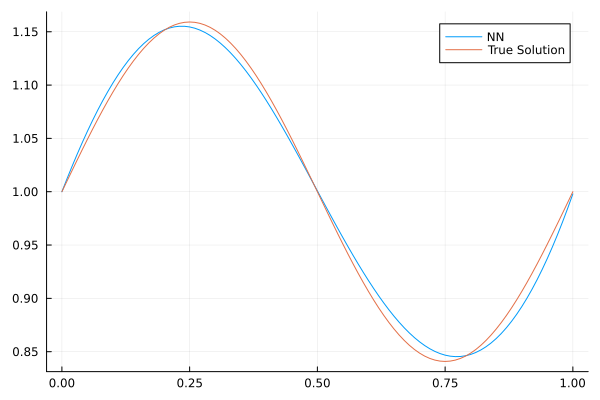

In [7]:
t = 0f0:1f-2:1f0
plot(t, g.(t), label="NN")
plot!(t,1.0 .+ sin.(2π.*t)/2π, label = "True Solution")

In [8]:
using DifferentialEquations

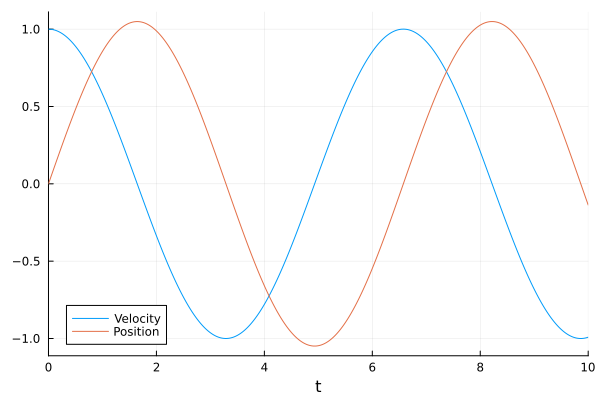

In [9]:
k = 1.0
force(dx,x,k,t) = -k*x + 0.1sin(x)
prob = SecondOrderODEProblem(force,1.0,0.0,(0.0,10.0),k)
sol = solve(prob)
plot(sol, label=["Velocity" "Position"])

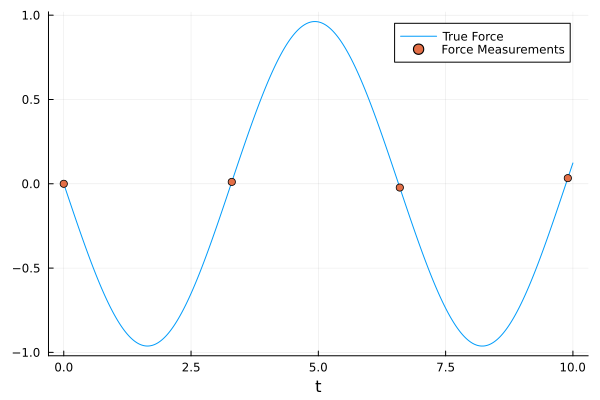

In [10]:
plot_t = 0:0.01:10
data_plot = sol(plot_t)
positions_plot = [state[2] for state in data_plot]
force_plot = [force(state[1],state[2],k,t) for state in data_plot]

t = 0:3.3:10
dataset = sol(t)
position_data = [state[2] for state in dataset]
force_data = [force(state[1],state[2],k,t) for state in dataset]

plot(plot_t,force_plot,xlabel="t",label="True Force")
scatter!(t,force_data,label="Force Measurements")

In [11]:
NNForce = Chain(Dense(1, 32, tanh),
                Dense(32, 1))

Chain(
  Dense(1 => 32, tanh),                 # 64 parameters
  Dense(32 => 1),                       # 33 parameters
)                   # Total: 4 arrays, 97 parameters, 596 bytes.

In [12]:
X = reshape(position_data, 1, :)
y = reshape(force_data, 1, :)

loss(m) = sum(abs2, m(X) .- y)

loss (generic function with 1 method)

In [13]:
# Optimiser + state
opt = Flux.Optimisers.Descent(0.01)
state = Flux.setup(opt, NNForce);

In [14]:
# Training loop
iter = 0
for epoch in 1:5000
    gs, = gradient(loss, NNForce)
    Flux.update!(state, NNForce, gs)
    
    if epoch % 500 == 0
        println("Epoch=$epoch, loss=$(loss(NNForce))")
    end
end

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(1 => 32, tanh)  # 64 parameters
│   summary(x) = "1×4 Matrix{Float64}"
└ @ Flux ~/.julia/packages/Flux/uRn8o/src/layers/stateless.jl:60


Epoch=500, loss=0.0017026587403487406
Epoch=1000, loss=0.0015069431451701538
Epoch=1500, loss=0.001333606019022519
Epoch=2000, loss=0.0011799503360254938
Epoch=2500, loss=0.0010436600082997275
Epoch=3000, loss=0.0009227322266887222
Epoch=3500, loss=0.0008154240125419265
Epoch=4000, loss=0.0007202106734028892
Epoch=4500, loss=0.0006357481348186822
Epoch=5000, loss=0.0005608500312458112


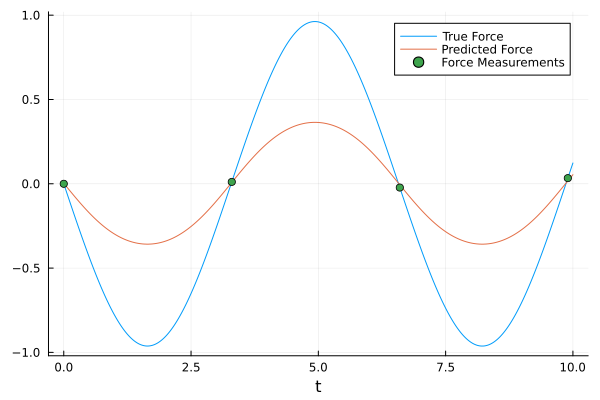

In [15]:
dat = reshape(positions_plot, 1, :)
learned_force_plot = NNForce(dat) |> vec

plot(plot_t,force_plot,xlabel="t",label="True Force")
plot!(plot_t,learned_force_plot,label="Predicted Force")
scatter!(t,force_data,label="Force Measurements")

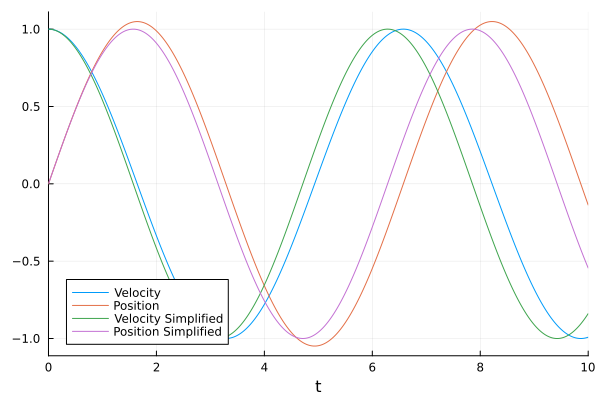

In [16]:
force2(dx,x,k,t) = -k*x
prob_simplified = SecondOrderODEProblem(force2, 1.0, 0.0, (0.0,10.0), k)
sol_simplified = solve(prob_simplified)
plot(sol,label=["Velocity" "Position"])
plot!(sol_simplified,label=["Velocity Simplified" "Position Simplified"])

In [17]:
X_new = [2rand()-1 for i in 1:100]
y_new = [-k*x for x in X_new]
X_new = reshape(X_new, 1, :)
y_new = reshape(y_new, 1, :)
loss_ode(m) = sum(abs2, m(X_new) .- y_new);

In [18]:
λ = 0.1
composed_loss(m) = loss(m) + λ*loss_ode(m);

In [19]:
opt = Flux.Optimisers.Descent(0.01)
state = Flux.setup(opt, NNForce);

In [20]:
# Training loop
iter = 0
for epoch in 1:5000
    gs, = gradient(composed_loss, NNForce)
    Flux.update!(state, NNForce, gs)
    
    if epoch % 500 == 0
        println("Epoch=$epoch, loss=$(loss(NNForce))")
    end
end

Epoch=500, loss=3.8520993832144534e-5
Epoch=1000, loss=3.747927879149992e-5
Epoch=1500, loss=3.661314732815943e-5
Epoch=2000, loss=3.5875819794617774e-5
Epoch=2500, loss=3.523628000720728e-5
Epoch=3000, loss=3.4673923319220795e-5
Epoch=3500, loss=3.417349349022017e-5
Epoch=4000, loss=3.372387799814092e-5
Epoch=4500, loss=3.331691411469449e-5
Epoch=5000, loss=3.294590012035969e-5


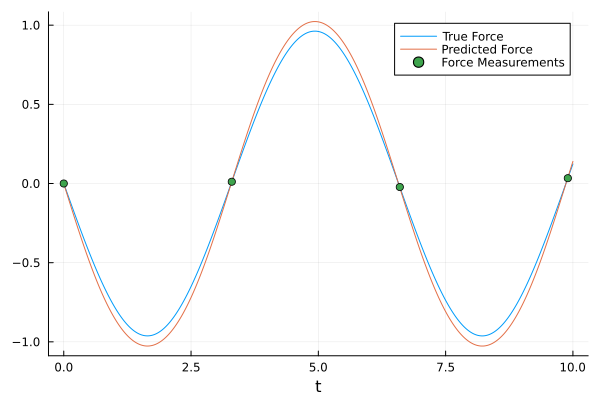

In [21]:
dat_new = reshape(positions_plot, 1, :)
learned_force_plot = NNForce(dat_new) |> vec
plot(plot_t,force_plot,xlabel="t",label="True Force")
plot!(plot_t,learned_force_plot,label="Predicted Force")
scatter!(t,force_data,label="Force Measurements")

In [22]:
NNBurgers = Chain(Dense(2, 32, tanh), Dense(32, 2));

In [23]:
nx = 100
L = 10.0
Δx = L/nx
t_end = 5.0
nt = 100
Δt = t_end/nt
ν = 0.1

x_range = 0.0f0:Float32(Δx):Float32(L)
t_range = 0.0f0:Float32(Δt):Float32(t_end)

xts = collect(Iterators.product(x_range, t_range))

ϵ = sqrt(eps(Float32))
# Loss with model as arg
#loss_data(m) = mean(abs2, ));
loss_pde(m) = mean(abs2, m())

loss_pde (generic function with 1 method)